In [1]:
#Loading all relevant modules (make sure they are all properly installed first)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os,sys,subprocess
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from tqdm import trange
import math
from math import pi
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, LogLocator, NullFormatter
import scienceplots
plt.style.use(['science','nature'])
plt.rcParams["axes.axisbelow"] = False
mpl.rcParams['text.usetex'] = False

In [2]:
#General setting when computing CMB spectra with Class
common_settings = {'output' :'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0,
                   # LambdaCDM parameters
                   '100*theta_s':1.041783, #We are fixing the value of the sound horizon (not h!)
                   'l_max_scalars':4000, #maximum value of \ell in CMB power spectra
                   'omega_b':0.02238280,
                   'A_s':2.100549e-09,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'compute_damping_scale':'yes'#We are computing directly the damping scale in Mpc
                   }

omega_cdm_LCDM=0.1201075 #\omega_cdm=|Omega_cdm*h^2
omega_b_LCDM=0.02238280 
omega_photon=2.47297928086*10**(-5)
omega_cdm_array=np.linspace(0,omega_cdm_LCDM+omega_b_LCDM,50)
omega_cdm_array_v2=np.linspace(0,omega_cdm_LCDM,50)[::-1]

#values of omega_b that keep omega_m= omega_b+ omega_cdm fixed:
omega_b_array=np.array([omega_b_LCDM -(i-omega_cdm_LCDM) for i in omega_cdm_array_v2])


In [3]:

#Function that computes CMB power spectra, i.e. C^{XX}_ls for X={T,E}
def Cl_computer(global_settings,specific_cosmo_settings,ell_max=4000):
    conv_factor=(2.726*10**(6))**2/10**(3) #Conversion factor from dimensionless units to 10^3 \muK^2
    cosmo=Class()
    cosmo.set(global_settings)
    cosmo.set(specific_cosmo_settings)
    cosmo.compute()
    cls = cosmo.lensed_cl(ell_max)
    ells = cls['ell'][2:]
    #Convert from C_ls to D_ls (parametrization for convenience)
    dTTs = cls['tt'][2:]*(ells*(ells+1))/(2*np.pi)*conv_factor
    dEEs = cls['ee'][2:]*ells*(ells+1)/(2*np.pi)*conv_factor
    cosmo.struct_cleanup()
    cosmo.empty()
    return ells,dTTs,dEEs

In [4]:
Cls_LCDM=Cl_computer(common_settings,{'omega_cdm':omega_cdm_LCDM})

In [5]:
#Compute the Cls for different values of omega_cdm
Cls_DMs=[]
Cls_LCDM=Cl_computer(common_settings,{'omega_cdm':omega_cdm_LCDM})
for i in trange(len(omega_cdm_array)):
    ells_cosmo,dTT_cosmo,dEE_cosmo=Cl_computer(common_settings,{'omega_cdm':omega_cdm_array[i]})
    Cls_DMs.append([ells_cosmo,dTT_cosmo,dEE_cosmo])
    del ells_cosmo, dTT_cosmo, dEE_cosmo
Cls_DMs=np.array(Cls_DMs)
#save in a file: Recall here we kept omega_b fixed:
np.save('Cls_DMs_fixed_omega_b',Cls_DMs)

100%|████████████████████████████████████████████████████████████| 50/50 [02:31<00:00,  3.02s/it]


In [6]:
#Compute the Cls for different values of omega_cdm
"""
Here we are keeping omega_m=omega_cdm+ omega_b fixed, which means that the moment of radiation-matter equality
is held fixed, i.e. a_{eq}\equiv omega_r/omega_m is fixed!
"""
Cls_DMs_aeq_fixed=[]
Cls_LCDM=Cl_computer(common_settings,{'omega_cdm':omega_cdm_LCDM,'omega_b':omega_b_LCDM,'YHe':0.245})

for i in trange(len(omega_cdm_array_v2)):
    ells_cosmo,dTT_cosmo,dEE_cosmo=Cl_computer(common_settings,{'omega_cdm':omega_cdm_array_v2[i],'omega_b':omega_b_array[i],'YHe':0.245})
    Cls_DMs_aeq_fixed.append([ells_cosmo,dTT_cosmo,dEE_cosmo])
    del ells_cosmo, dTT_cosmo, dEE_cosmo
Cls_DMs_aeq_fixed=np.array(Cls_DMs_aeq_fixed)
#save in a file: Recall here we kept aeq fixed:
np.save('Cls_DMs_fixed_aeq',Cls_DMs_aeq_fixed)

100%|████████████████████████████████████████████████████████████| 50/50 [02:29<00:00,  2.98s/it]


# $\omega_b$ constant

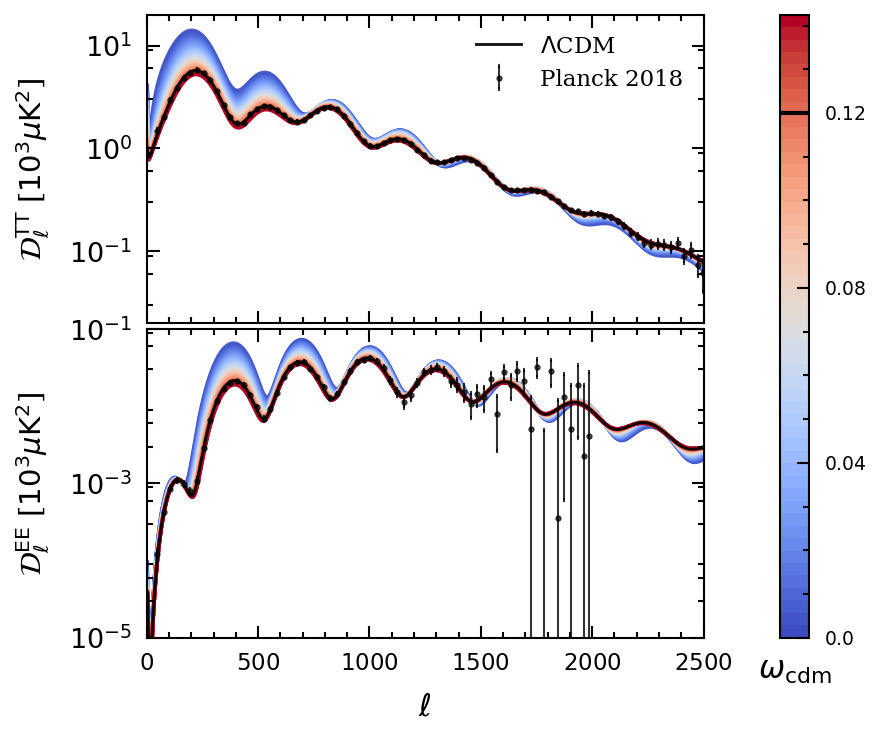

In [10]:
Cls_DMs=np.load('Cls_DMs_fixed_omega_b.npy',allow_pickle=True)

#Load Planck data:
Planck_EE_spectrum =np.loadtxt('COM_PowerSpect_CMB-EE-binned_R3.02.txt', skiprows=1)
Planck_TT_spectrum =np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt', skiprows=1)

#Create figure
fig1=plt.figure(figsize=(3,3),dpi=300)
gs1 = GridSpec(20,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:10,1:-3])
ax2 = fig1.add_subplot(gs1[10:-1,1:-3])
axDM = fig1.add_subplot(gs1[1:-1,-1])

color_DM= plt.cm.coolwarm(np.linspace(0, 1, len(omega_cdm_array)))

#Relevant lines to create colorbar
cmap = plt.get_cmap('coolwarm', len(Cls_DMs))
norm = mpl.colors.Normalize(vmin=np.min(omega_cdm_array), vmax=np.max(omega_cdm_array)) # Normalizer
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # creating ScalarMappable
sm.set_array([])

ax1.tick_params(axis='both', which='major', labelsize=6.5)
ax1.tick_params(axis='both', which='minor', labelsize=6.5)
ax2.tick_params(axis='both', which='major', labelsize=6.5)
ax2.tick_params(axis='both', which='minor', labelsize=6.5)

for i in range(len(omega_cdm_array)):
    ax1.plot(Cls_DMs[i][0],Cls_DMs[i][1],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')
    ax2.plot(Cls_DMs[i][0],Cls_DMs[i][2],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')

ax1.set_yscale('log')
ax2.set_yscale('log')
axDM.tick_params(axis='both', which='major', labelsize=6.5)
axDM.tick_params(axis='both', which='minor', labelsize=6.5)
axDM.set_xticks([])
# Move y-axis ticks and labels to the right
axDM.yaxis.tick_right()
axDM.yaxis.set_label_position("right")
#Create Horizontal bar on axDM indicating LCDM value of omega_CDM:
axDM.axhline(omega_cdm_LCDM, color='black', linewidth=1)  # Add the horizontal line
plt.colorbar(sm,cax=axDM)
axDM.set_yticks([0,0.04,0.08,0.12])
axDM.set_yticklabels([r'$0.0$',r'$0.04$',r'$0.08$',r'$0.12$'],fontdict={'family':'serif','fontsize':4.5})
ax1.plot(Cls_LCDM[0],Cls_LCDM[1],c='k',alpha=0.9,lw=0.7,ls='solid', label=r'$\Lambda$CDM')
ax2.plot(Cls_LCDM[0],Cls_LCDM[2],c='k',alpha=0.9,lw=0.7,ls='solid')
ax1.errorbar(Planck_TT_spectrum[:,0],Planck_TT_spectrum[:,1]/1e3,yerr=np.array([Planck_TT_spectrum[:,2]/1e3,Planck_TT_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5, label='Planck 2018')
ax2.errorbar(Planck_EE_spectrum[:,0],Planck_EE_spectrum[:,1]/1e3,yerr=np.array([Planck_EE_spectrum[:,2]/1e3,Planck_EE_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5)

ax1.set_ylim(2e-2,2e1)
ax2.set_ylim(1e-5,1e-1)
ax1.set_xlim(0,2500)
ax2.set_xlim(0,2500)
ax1.set_xticks([0,500,1000,1500,2000,2500])
ax2.set_xticks([0,500,1000,1500,2000,2500])
ax1.set_xticklabels([])
ax2.set_xticklabels([r'$0$',r'$500$',r'$1000$',r'$1500$',r'$2000$',r'$2500$'],fontdict={'family':'serif','fontsize':5.5})

ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
ax2.yaxis.set_minor_formatter(NullFormatter())
ax1.set_ylabel(r"$\mathcal{D}^{\rm{TT}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
ax2.set_ylabel(r"$\mathcal{D}^{\rm{EE}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
ax2.set_xlabel(r"$\ell$",fontdict={'fontsize':7.5,'family':'serif'})
axDM.set_xlabel(r"$\omega_{\rm{cdm}}$",fontdict={'fontsize':7.5,'family':'serif'})
ax1.legend(prop={'family':'serif','size':5.5})
plt.show()
plt.close()

In [12]:
################################################
##   Script to create multiple plots for gif  ##
################################################

for i in trange(len(omega_cdm_array)):
    fig1=plt.figure(figsize=(3,3),dpi=300)
    gs1 = GridSpec(20,20,figure=fig1)
    ax1 = fig1.add_subplot(gs1[1:10,1:-3])
    ax2 = fig1.add_subplot(gs1[10:-1,1:-3])
    axDM = fig1.add_subplot(gs1[1:-1,-1])

    color_DM= plt.cm.coolwarm(np.linspace(0, 1, len(omega_cdm_array)))
    cmap = plt.get_cmap('coolwarm', len(Cls_DMs))
    if i!=0:
        color_DM[i+1:]=[1,1,1,1]
    custom_cmap= mpl.colors.ListedColormap(color_DM)
    # Normalizer
    norm = mpl.colors.Normalize(vmin=np.min(omega_cdm_array), vmax=np.max(omega_cdm_array))
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)

    sm.set_array([])

    ax1.tick_params(axis='both', which='major', labelsize=6.5)
    ax1.tick_params(axis='both', which='minor', labelsize=6.5)
    ax2.tick_params(axis='both', which='major', labelsize=6.5)
    ax2.tick_params(axis='both', which='minor', labelsize=6.5)
    ax1.plot(Cls_DMs[i][0],Cls_DMs[i][1],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')
    ax2.plot(Cls_DMs[i][0],Cls_DMs[i][2],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')
    ax1.set_ylim(2e-2,2e1)
    ax2.set_ylim(1e-5,1e-1)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    axDM.tick_params(axis='both', which='major', labelsize=6.5)
    axDM.tick_params(axis='both', which='minor', labelsize=6.5)
    axDM.set_xticks([])
    # Move y-axis ticks and labels to the right
    axDM.yaxis.tick_right()
    axDM.yaxis.set_label_position("right")

    plt.colorbar(sm,cax=axDM)
    axDM.set_yticks([0,0.04,0.08,0.12])
    axDM.set_yticklabels([r'$0.0$',r'$0.04$',r'$0.08$',r'$0.12$'],fontdict={'family':'serif','fontsize':4.5})
    ax1.plot(Cls_LCDM[0],Cls_LCDM[1],c='k',alpha=0.9,lw=0.7,ls='solid', label=r'$\Lambda$CDM')
    ax2.plot(Cls_LCDM[0],Cls_LCDM[2],c='k',alpha=0.9,lw=0.7,ls='solid')
    ax1.errorbar(Planck_TT_spectrum[:,0],Planck_TT_spectrum[:,1]/1e3,yerr=np.array([Planck_TT_spectrum[:,2]/1e3,Planck_TT_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5, label='Planck 2018')
    ax2.errorbar(Planck_EE_spectrum[:,0],Planck_EE_spectrum[:,1]/1e3,yerr=np.array([Planck_EE_spectrum[:,2]/1e3,Planck_EE_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5)

    ax1.set_xlim(0,2500)
    ax2.set_xlim(0,2500)
    ax1.set_xticks([0,500,1000,1500,2000,2500])
    ax2.set_xticks([0,500,1000,1500,2000,2500])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([r'$0$',r'$500$',r'$1000$',r'$1500$',r'$2000$',r'$2500$'],fontdict={'family':'serif','fontsize':5.5})

    ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
    ax1.yaxis.set_minor_formatter(NullFormatter())
    ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
    ax2.yaxis.set_minor_formatter(NullFormatter())
    ax1.set_ylabel(r"$\mathcal{D}^{\rm{TT}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
    ax2.set_ylabel(r"$\mathcal{D}^{\rm{EE}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
    ax2.set_xlabel(r"$\ell$",fontdict={'fontsize':7.5,'family':'serif'})
    axDM.set_xlabel(r"$\omega_{\rm{cdm}}$",fontdict={'fontsize':7.5,'family':'serif'})
    ax1.legend(prop={'family':'serif','size':5.5})
    plt.savefig('omega_cdm_gif/Dl_omega_cdm_v'+str(i+1)+'.png',bbox_inches='tight',dpi=300)
    plt.close()
    del fig1

100%|████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


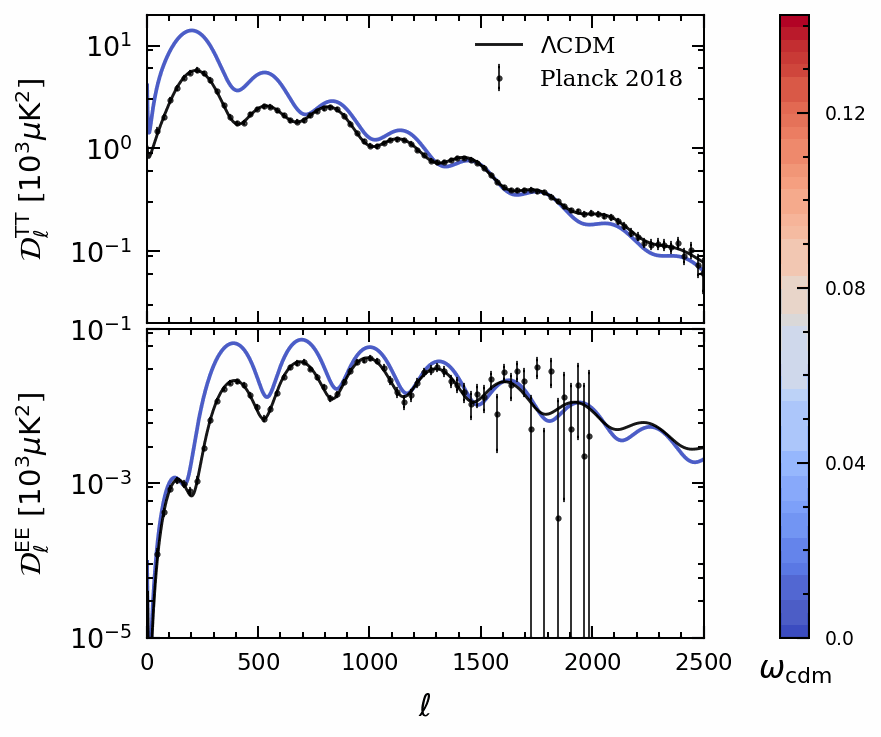

In [13]:
from PIL import Image as Im

from IPython.display import Image, display

################################################
##         Script to actualy creat gif        ##
################################################

images = [Im.open('omega_cdm_gif/Dl_omega_cdm_v'+str(i+1)+'.png') for i in range(len(omega_cdm_array))]

# Save the images as a GIF
images[0].save('omega_cdm_gif/Dl_omega_cdm.gif', save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
# Display the GIF in the notebook
display(Image('omega_cdm_gif/Dl_omega_cdm.gif'))

# $a_{\rm{eq}}$ constant

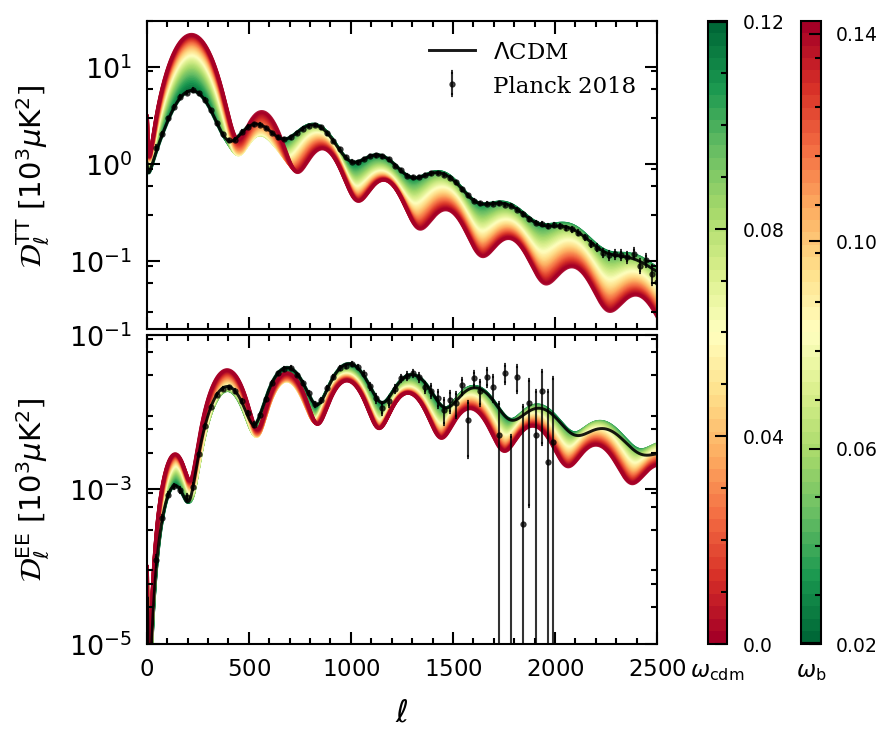

In [14]:
#Load Planck data:
Planck_EE_spectrum =np.loadtxt('COM_PowerSpect_CMB-EE-binned_R3.02.txt', skiprows=1)
Planck_TT_spectrum =np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt', skiprows=1)

Cls_DMs_aeq_fixed=np.load('Cls_DMs_fixed_aeq.npy')

fig1=plt.figure(figsize=(3,3),dpi=300)
gs1 = GridSpec(20,30,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:10,1:-7])
ax2 = fig1.add_subplot(gs1[10:-1,1:-7])
axDM = fig1.add_subplot(gs1[1:-1,-5])
axb = fig1.add_subplot(gs1[1:-1,-1])

color_DM= plt.cm.RdYlGn(np.linspace(0, 1, len(omega_cdm_array_v2)))[::-1]
cmap_b = plt.get_cmap('RdYlGn', len(Cls_DMs_aeq_fixed)).reversed()
norm_b = mpl.colors.Normalize(vmin=np.min(omega_b_array), vmax=np.max(omega_b_array))
sm_b = plt.cm.ScalarMappable(cmap=cmap_b, norm=norm_b)
sm_b.set_array([])
plt.colorbar(sm_b,cax=axb)
axb.tick_params(axis='both', which='major', labelsize=6.5)
axb.tick_params(axis='both', which='minor', labelsize=6.5)
axb.set_xticks([])
axb.yaxis.tick_right()
axb.yaxis.set_label_position("right")
axb.set_yticks([0.02238280,0.06,0.10,0.14])
axb.set_yticklabels([r'$0.02$',r'$0.06$',r'$0.10$',r'$0.14$'],fontdict={'family':'serif','fontsize':4.5})

axb.axhline(omega_b_LCDM, color='black', linewidth=1)  # Add the horizontal line


cmap = plt.get_cmap('RdYlGn', len(Cls_DMs_aeq_fixed))

# Normalizer
norm = mpl.colors.Normalize(vmin=np.min(omega_cdm_array_v2), vmax=np.max(omega_cdm_array_v2))

# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sm.set_array([])

ax1.tick_params(axis='both', which='major', labelsize=6.5)
ax1.tick_params(axis='both', which='minor', labelsize=6.5)
ax2.tick_params(axis='both', which='major', labelsize=6.5)
ax2.tick_params(axis='both', which='minor', labelsize=6.5)

for i in range(len(omega_cdm_array_v2)):
    ax1.plot(Cls_DMs_aeq_fixed[i][0],Cls_DMs_aeq_fixed[i][1],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')
    ax2.plot(Cls_DMs_aeq_fixed[i][0],Cls_DMs_aeq_fixed[i][2],color=color_DM[i],alpha=0.9,lw=0.9,ls='solid')

axDM.tick_params(axis='both', which='major', labelsize=6.5)
axDM.tick_params(axis='both', which='minor', labelsize=6.5)
axDM.set_xticks([])
axDM.yaxis.tick_right()
axDM.yaxis.set_label_position("right")
#Create Horizontal bar on axDM indicating LCDM value of omega_CDM:
axDM.axhline(omega_cdm_LCDM, color='black', linewidth=1)  # Add the horizontal line
plt.colorbar(sm,cax=axDM)
axDM.set_yticks([0,0.04,0.08,0.12])
axDM.set_yticklabels([r'$0.0$',r'$0.04$',r'$0.08$',r'$0.12$'],fontdict={'family':'serif','fontsize':4.5})


ax1.plot(Cls_LCDM[0],Cls_LCDM[1],c='k',alpha=0.9,lw=0.7,ls='solid', label=r'$\Lambda$CDM')
ax2.plot(Cls_LCDM[0],Cls_LCDM[2],c='k',alpha=0.9,lw=0.7,ls='solid')
ax1.errorbar(Planck_TT_spectrum[:,0],Planck_TT_spectrum[:,1]/1e3,yerr=np.array([Planck_TT_spectrum[:,2]/1e3,Planck_TT_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5, label='Planck 2018')
ax2.errorbar(Planck_EE_spectrum[:,0],Planck_EE_spectrum[:,1]/1e3,yerr=np.array([Planck_EE_spectrum[:,2]/1e3,Planck_EE_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5)


ax1.set_xlim(0,2500)
ax2.set_xlim(0,2500)
ax1.set_xticks([0,500,1000,1500,2000,2500])
ax2.set_xticks([0,500,1000,1500,2000,2500])
ax1.set_xticklabels([])
ax2.set_xticklabels([r'$0$',r'$500$',r'$1000$',r'$1500$',r'$2000$',r'$2500$'],fontdict={'family':'serif','fontsize':5.5})

ax1.set_ylim(2e-2,3e1)
ax2.set_ylim(1e-5,1e-1)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
ax2.yaxis.set_minor_formatter(NullFormatter())

ax1.set_ylabel(r"$\mathcal{D}^{\rm{TT}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
ax2.set_ylabel(r"$\mathcal{D}^{\rm{EE}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
ax2.set_xlabel(r"$\ell$",fontdict={'fontsize':7.5,'family':'serif'})
axDM.set_xlabel(r"$\omega_{\rm{cdm}}$",fontdict={'fontsize':5.5,'family':'serif'})
axb.set_xlabel(r"$\omega_{\rm{b}}$",fontdict={'fontsize':5.5,'family':'serif'})
ax1.legend(prop={'family':'serif','size':5.5})
plt.show()
plt.close()

In [15]:
#Load Planck data:
Planck_EE_spectrum =np.loadtxt('COM_PowerSpect_CMB-EE-binned_R3.02.txt', skiprows=1)
Planck_TT_spectrum =np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt', skiprows=1)

Cls_DMs_aeq_fixed=np.load('Cls_DMs_fixed_aeq.npy')
for i in trange(len(omega_cdm_array_v2)):
    fig1=plt.figure(figsize=(3,3),dpi=300)
    gs1 = GridSpec(20,30,figure=fig1)
    ax1 = fig1.add_subplot(gs1[1:10,1:-8])
    ax2 = fig1.add_subplot(gs1[10:-1,1:-8])
    axDM = fig1.add_subplot(gs1[1:-1,-5])
    axb = fig1.add_subplot(gs1[1:-1,-1])

    color_DM= plt.cm.RdYlGn(np.linspace(0, 1, len(omega_cdm_array_v2)))
    if i!=0:
        color_DM[50-i:]=[1,1,1,1]
    custom_cmap= mpl.colors.ListedColormap(color_DM)
    # Normalizer
    #norm = mpl.colors.Normalize(vmin=np.min(omega_cdm_array_v2), vmax=np.max(omega_cdm_array_v2))
    norm = mpl.colors.Normalize(vmin=np.min(omega_cdm_array_v2/0.67810**2), vmax=np.max(omega_cdm_array_v2/0.67810**2))
    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    custom_cmap_b =mpl.colors.ListedColormap(color_DM).reversed()
    norm_b = mpl.colors.Normalize(vmin=np.min(omega_b_array/0.67810**2), vmax=np.max(omega_b_array/0.67810**2))
    sm_b = plt.cm.ScalarMappable(cmap=custom_cmap_b, norm=norm_b)
    sm_b.set_array([])
    plt.colorbar(sm_b,cax=axb)
    axb.tick_params(axis='both', which='major', labelsize=6.5)
    axb.tick_params(axis='both', which='minor', labelsize=6.5)
    axb.set_xticks([])
    axb.yaxis.tick_right()
    axb.yaxis.set_label_position("right")
    axb.set_yticks([0.02238280/0.67810**2,0.1,0.15,0.20,0.25,0.30])
    axb.set_yticklabels([r'$5$',r'$10$',r'$15$',r'$20$',r'$25$',r'$30$'],fontdict={'family':'serif','fontsize':4.5})

    axb.axhline(omega_b_LCDM, color='black', linewidth=1)  # Add the horizontal line
    ax1.tick_params(axis='both', which='major', labelsize=6.5)
    ax1.tick_params(axis='both', which='minor', labelsize=6.5)
    ax2.tick_params(axis='both', which='major', labelsize=6.5)
    ax2.tick_params(axis='both', which='minor', labelsize=6.5)


    ax1.plot(Cls_DMs_aeq_fixed[i][0],Cls_DMs_aeq_fixed[i][1],color=color_DM[49-i],alpha=0.9,lw=0.9,ls='solid')
    ax2.plot(Cls_DMs_aeq_fixed[i][0],Cls_DMs_aeq_fixed[i][2],color=color_DM[49-i],alpha=0.9,lw=0.9,ls='solid')

    axDM.tick_params(axis='both', which='major', labelsize=6.5)
    axDM.tick_params(axis='both', which='minor', labelsize=6.5)
    axDM.set_xticks([])
    axDM.yaxis.tick_right()
    axDM.yaxis.set_label_position("right")
    plt.colorbar(sm,cax=axDM)
    axDM.set_yticks([0,0.05,0.10,0.15,0.20,0.25])
    axDM.set_yticklabels([r'$0$',r'$5$',r'$10$',r'$15$',r'$20$',r'$25$'],fontdict={'family':'serif','fontsize':4.5})


    ax1.plot(Cls_LCDM[0],Cls_LCDM[1],c='k',alpha=0.9,lw=0.7,ls='solid', label=r'$\Lambda$CDM')
    ax2.plot(Cls_LCDM[0],Cls_LCDM[2],c='k',alpha=0.9,lw=0.7,ls='solid')
    ax1.errorbar(Planck_TT_spectrum[:,0],Planck_TT_spectrum[:,1]/1e3,yerr=np.array([Planck_TT_spectrum[:,2]/1e3,Planck_TT_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5, label='Planck 2018')
    ax2.errorbar(Planck_EE_spectrum[:,0],Planck_EE_spectrum[:,1]/1e3,yerr=np.array([Planck_EE_spectrum[:,2]/1e3,Planck_EE_spectrum[:,3]/1e3]),marker='o',markersize=0.5, ls='none',ecolor='k', capsize=0.2, c='k',alpha=0.8,elinewidth=0.5)


    ax1.set_xlim(0,2500)
    ax2.set_xlim(0,2500)
    ax1.set_xticks([0,500,1000,1500,2000,2500])
    ax2.set_xticks([0,500,1000,1500,2000,2500])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([r'$0$',r'$500$',r'$1000$',r'$1500$',r'$2000$',r'$2500$'],fontdict={'family':'serif','fontsize':5.5})

    ax1.set_ylim(2e-2,3e1)
    ax2.set_ylim(1e-5,1e-1)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
    ax1.yaxis.set_minor_formatter(NullFormatter())
    ax2.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.3,0.6,0.9],
                                      numticks=100))
    ax2.yaxis.set_minor_formatter(NullFormatter())

    ax1.set_ylabel(r"$\mathcal{D}^{\rm{TT}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
    ax2.set_ylabel(r"$\mathcal{D}^{\rm{EE}}_\ell$ [$10^{3}\mu\rm{K}^2$]",fontdict={'fontsize':7,'family':'serif'})
    ax2.set_xlabel(r"$\ell$",fontdict={'fontsize':7.5,'family':'serif'})
    axDM.set_xlabel(r"$\Omega_{\rm{cdm}}\, (\%)$ ",fontdict={'fontsize':5.5,'family':'serif'})
    axb.set_xlabel(r"$\Omega_{\rm{b}}\, (\%)$",fontdict={'fontsize':5.5,'family':'serif'})
    ax1.legend(prop={'family':'serif','size':5.5})
    plt.savefig('omega_cdm_gif/Dl_omega_cdm_fixed_aeq_v'+str(50-i)+'_new.png',bbox_inches='tight',dpi=300)
    plt.close()
    del fig1

100%|████████████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/it]


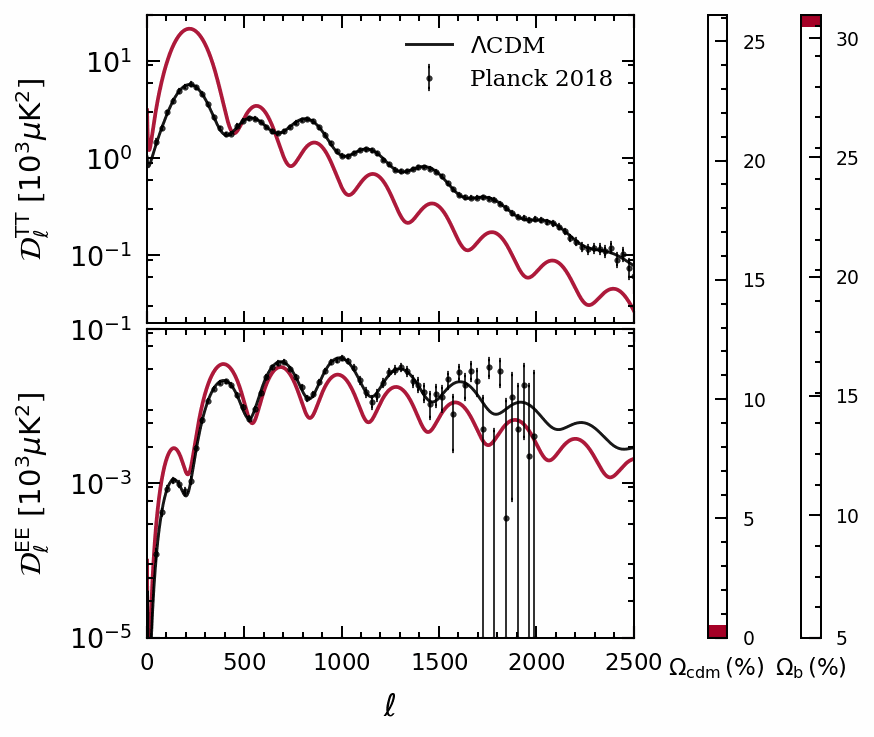

In [16]:
from PIL import Image as Im

from IPython.display import Image, display

################################################
##         Script to actualy creat gif        ##
################################################

images = [Im.open('omega_cdm_gif/Dl_omega_cdm_fixed_aeq_v'+str(i+1)+'_new.png') for i in range(len(omega_cdm_array_v2))]
durations=[]
for i in range(len(omega_cdm_array_v2)):
    if i<=40:
        durations.append(200)
    else:
        durations.append(int(200+(i+1)*10))
# Save the images as a GIF
images[0].save('omega_cdm_gif/Dl_omega_cdm_fixed_aeq_new.gif', save_all=True, append_images=images[1:], optimize=False, duration=durations, loop=0)
# Display the GIF in the notebook
display(Image('omega_cdm_gif/Dl_omega_cdm_fixed_aeq_new.gif'))